In [1]:
!pip install datasets -q
!pip install peft -q
!pip install accelerate -q
!pip install transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incomp

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"  # <- hard off switch
# (alias works too in some builds)
os.environ["TORCH_COMPILE_DISABLE"] = "1"

In [3]:
import re
import time
import gc
import ctypes
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.utils import shuffle
from transformers import get_cosine_schedule_with_warmup

2025-08-15 07:22:18.981031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755242539.175453      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755242539.230051      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reward Functions

This is accuracy reward which is rewarded for correct output.

In [4]:
def accuracy_reward(prompt_completions, answer):
    rewards = []
    for pc in prompt_completions:
        completion = pc.split('<answer>')[-1]
        if answer in completion and (pc.count('<answer>') == 2):
            rewards.append(2.0)
        else:
            rewards.append(0.0)
    return rewards

This rewards for maintaining the format.

Penalizing for generating many `<eos>` tokens

In [5]:
def format_reward(prompt_completions, eos_penalty=0.2):
    completions = []
    for pc in prompt_completions:
        completion = pc.split('\nAssistant:')[-1]
        count_eos_string = completion.count(tokenizer.eos_token)

        # Fix duplicate EOS in the text (optional clean-up)
        if count_eos_string > 1:
            completion = completion.replace(tokenizer.eos_token, '')
            completion = completion + tokenizer.eos_token
        
        completions.append(completion)

    rewards = []
    pattern = re.compile(
        r".*<reasoning>\n.+?\n</reasoning>\n<answer>\n.+?\n</answer>",
        re.DOTALL
    )

    for completion in completions:
        # Base reward for matching format
        base_reward = 0.5 if pattern.fullmatch(completion) else 0.0
        
        # Count EOS tokens
        eos_count = completion.count(tokenizer.eos_token)
        
        # Apply penalty if there are too many EOS tokens
        penalty = eos_penalty * max(0, eos_count - 1)  # penalize each extra EOS beyond 1
        
        rewards.append(base_reward - penalty)

    return rewards


## Load and Process Data

In [6]:
import datasets

data = datasets.load_dataset('openai/gsm8k', 'main')

df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

### Extract Answer

In [7]:
df_train['answer'] = df_train['answer'].str.split('####').str[-1].str.strip()
df_test['answer'] = df_test['answer'].str.split('####').str[-1].str.strip()

## Create and Apply Chat Template

In [8]:
SYSTEM = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

In [9]:
df_train['prompt'] = SYSTEM + 'User: ' + df_train['question'].str.strip() + '\nAssistant:'
df_test['prompt'] = SYSTEM + 'User: ' + df_test['question'].str.strip() + '\nAssistant:'

In [10]:
print(df_train.prompt[69])


Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User: Carly collected 7 starfish with 5 arms each and one seastar with 14 arms. How many arms do the animals she collected have in total?
Assistant:


In [11]:
model_path = 'google/gemma-3-270m' 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device
)

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

In [13]:
peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
        bias='none',
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0
    )

model = get_peft_model(model, peft_config)

In [14]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device
).eval().requires_grad_(False)

In [15]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

## Completion Generation Function

In [16]:
model.generate = torch._dynamo.disable()(model.generate)

def generate_completions(model, tokenizer, prompts, temperature=0.9, num_completions=2, max_completion_length=50):
    
    model.eval() 
    
    completions = []
    for prompt in tqdm(prompts):

        encodings = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # Generate completions using the current policy
        with torch.inference_mode():
            outs = model.generate(
                **encodings, 
                do_sample=True, 
                temperature=temperature, 
                max_new_tokens=max_completion_length,  # Limiting the number of tokens generated
                num_return_sequences=num_completions,  # Number of generations per prompt
                pad_token_id=tokenizer.eos_token_id
            )
        
        decoded_texts = tokenizer.batch_decode(outs, skip_special_tokens=False)
        completions.extend(decoded_texts)
        
    model.train()
    
    return completions

## Get Log Probs Function

In [17]:
def get_log_probs(model, prompt, prompt_completions, type):
    
    if type == 'new':
        prompt_ids = tokenizer(prompt)
        prompt_len = len(prompt_ids)
        encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)

        with autocast(dtype=torch.bfloat16, device_type='cuda'):
            logits = model(**encodings).logits

    else:
        with torch.no_grad():
            prompt_ids = tokenizer(prompt)
            prompt_len = len(prompt_ids)
            encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)
    
            with autocast(dtype=torch.bfloat16, device_type='cuda'):
                logits = model(**encodings).logits
        
    start = len(tokenizer(prompt).input_ids) 

    all_log_probs = []
    for l, input_ids in zip(logits, encodings.input_ids):
        eos_pos = torch.where(input_ids == tokenizer.eos_token_id)[0]

        if eos_pos.numel() == 0:
            completion_logits = l[start-1:-1]
            completion_ids = input_ids[start:] 
        else:
            end = eos_pos[0].item() 
            completion_logits = l[start-1:end]
            completion_ids = input_ids[start:end+1]

        probs = F.softmax(completion_logits, dim=-1)
        log_probs = torch.log(probs)
        log_probs = torch.gather(log_probs, 1, completion_ids.unsqueeze(1)).squeeze(1)
        all_log_probs.append(log_probs)

    return all_log_probs

In [18]:
def check(t):
    print('ISNAN', torch.isnan(t).any())
    print('ISINF', torch.isinf(t).any())

## Hyperparameters

In [19]:
epochs = 1
n_iterations = 5
learning_rate = 3e-5
weight_decay = 0.005
warmups = 100

eps = 0.2
beta = 0.005

## Training 

In [20]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [21]:
prompts, answers = shuffle(df_train.prompt, df_train.answer)

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_training_steps=epochs*len(prompts)*n_iterations,
                                            num_warmup_steps=warmups)

scaler = GradScaler()

In [23]:
start_time = time.time()
max_duration = 3 * 60 * 60  


reward_tracking = []
total_rewards = []
track_format_rewards = []
track_accuracy_rewards = []

step = 0
for epoch in range(epochs):
    for idx in range(len(df_train)):
        step += 1

        if time.time() - start_time > max_duration:
            print("Stopping training: Reached 11-hour limit.")
            break
        
        prompt = prompts[idx]
        answer = answers[idx]
        
        prompt_completions = generate_completions(
            model=model,
            tokenizer=tokenizer,
            prompts=[prompt],
            temperature=0.8, 
            num_completions=5,
            max_completion_length=512)

        accuracy_rewards = accuracy_reward(prompt_completions, answer)
        format_rewards = format_reward(prompt_completions)
        rewards = torch.tensor(accuracy_rewards) + torch.tensor(format_rewards)
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

        old_log_probs = get_log_probs(model, prompt, prompt_completions, type='old')
        ref_log_probs = get_log_probs(ref_model, prompt, prompt_completions, type='ref')
    

        for i_iter in range(n_iterations):
            if time.time() - start_time > max_duration:
                print("Stopping training: Reached 3-hour limit.")
                break
            
            new_log_probs = get_log_probs(model, prompt, prompt_completions, type='new')

            loss = 0
            for i in range(len(old_log_probs)):
                ratio = torch.exp(new_log_probs[i] - old_log_probs[i]) 
                clipped_ratio = torch.clamp(ratio, min=1-eps, max=1+eps)

                kl_ratio1 = torch.exp(ref_log_probs[i] - new_log_probs[i]) 
                kl_ratio2 = torch.exp(ref_log_probs[i] - new_log_probs[i]).log()
                kl = kl_ratio1 - kl_ratio2 - 1
                
                loss += (-clipped_ratio * advantages[i] - beta*kl).mean()
                
            loss = loss / len(new_log_probs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            clean_memory()
            
            print(f"Step: {step} | Iter: {i_iter+1} | Loss", loss.item())

        track_format_rewards.append(sum(format_rewards) / len(format_rewards))
        track_accuracy_rewards.append(sum(accuracy_rewards) / len(accuracy_rewards))
        total_rewards.append(sum(rewards)/len(rewards))
        
        if step % 10 == 0:
            print(
                f'Step: {step}'
                f' | Format: {sum(track_format_rewards)/len(track_format_rewards)}'
                f' | Accuracy: {sum(track_accuracy_rewards)/len(track_accuracy_rewards)}'
            )


            print('Output example:', prompt_completions[0].split('\nAssistant:')[1].strip())

100%|██████████| 1/1 [00:28<00:00, 28.17s/it]
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step: 1 | Iter: 1 | Loss 0.0
Step: 1 | Iter: 2 | Loss 0.0
Step: 1 | Iter: 3 | Loss 0.0
Step: 1 | Iter: 4 | Loss 0.0
Step: 1 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.27s/it]


Step: 2 | Iter: 1 | Loss 0.0
Step: 2 | Iter: 2 | Loss 0.0
Step: 2 | Iter: 3 | Loss 0.0
Step: 2 | Iter: 4 | Loss 0.0
Step: 2 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.21s/it]


Step: 3 | Iter: 1 | Loss 0.0
Step: 3 | Iter: 2 | Loss 0.0
Step: 3 | Iter: 3 | Loss 0.0
Step: 3 | Iter: 4 | Loss 0.0
Step: 3 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:27<00:00, 27.37s/it]


Step: 4 | Iter: 1 | Loss -1.8030405044555664e-06
Step: 4 | Iter: 2 | Loss -1.2367963790893555e-06
Step: 4 | Iter: 3 | Loss -1.0207295417785645e-06
Step: 4 | Iter: 4 | Loss -2.5331974029541016e-06
Step: 4 | Iter: 5 | Loss -2.4437904357910156e-06


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]


Step: 5 | Iter: 1 | Loss -3.03611159324646e-07
Step: 5 | Iter: 2 | Loss -2.738088369369507e-07
Step: 5 | Iter: 3 | Loss -3.203749656677246e-07
Step: 5 | Iter: 4 | Loss -3.6694109439849854e-07
Step: 5 | Iter: 5 | Loss -2.8870999813079834e-07


100%|██████████| 1/1 [00:27<00:00, 27.45s/it]


Step: 6 | Iter: 1 | Loss -4.880130290985107e-07
Step: 6 | Iter: 2 | Loss -3.4831464290618896e-07
Step: 6 | Iter: 3 | Loss -6.370246410369873e-07
Step: 6 | Iter: 4 | Loss -3.9674341678619385e-07
Step: 6 | Iter: 5 | Loss -3.6694109439849854e-07


100%|██████████| 1/1 [00:27<00:00, 27.37s/it]


Step: 7 | Iter: 1 | Loss -4.5634806156158447e-07
Step: 7 | Iter: 2 | Loss -6.258487701416016e-07
Step: 7 | Iter: 3 | Loss -5.476176738739014e-07
Step: 7 | Iter: 4 | Loss -5.774199962615967e-07
Step: 7 | Iter: 5 | Loss -5.923211574554443e-07


100%|██████████| 1/1 [00:27<00:00, 27.57s/it]


Step: 8 | Iter: 1 | Loss -4.675239324569702e-07
Step: 8 | Iter: 2 | Loss -3.2223761081695557e-07
Step: 8 | Iter: 3 | Loss -6.258487701416016e-07
Step: 8 | Iter: 4 | Loss -6.034970283508301e-07
Step: 8 | Iter: 5 | Loss -4.991888999938965e-07


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 9 | Iter: 1 | Loss -8.419156074523926e-07
Step: 9 | Iter: 2 | Loss -1.1548399925231934e-06
Step: 9 | Iter: 3 | Loss -6.407499313354492e-07
Step: 9 | Iter: 4 | Loss -7.860362529754639e-07
Step: 9 | Iter: 5 | Loss -1.2814998626708984e-06


100%|██████████| 1/1 [00:27<00:00, 27.45s/it]


Step: 10 | Iter: 1 | Loss -9.015202522277832e-07
Step: 10 | Iter: 2 | Loss -1.2218952178955078e-06
Step: 10 | Iter: 3 | Loss -9.685754776000977e-07
Step: 10 | Iter: 4 | Loss -1.3932585716247559e-06
Step: 10 | Iter: 5 | Loss -1.1026859283447266e-06
Step: 10 | Format: 0.0 | Accuracy: 0.04
Output example: My work day is 7:45am to 4:15pm.  If I work 75% of my 8 hour shift, how much will I make if I work 15 hours per week?

<strong>This question is similar to:</strong>
Question 2 (1 mark)
A person makes $7 an hour and works 18 hours per week.  If the pay is $8.50 an hour, how much money will she make if she works 31 hours per week?
<strong>Expert Answer:</strong>
You may have a hard time answering this question because you forgot to answer the part B.

<strong>You will need to answer this part in the following format:</strong>
<reasoning>
...
</reasoning>
<answer>
...
</answer>
<answer>
...
</answer><eos>I will try to give you the answer as soon as possible.

<reasoning>
...
</reasoning>
<a

100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 11 | Iter: 1 | Loss -5.811452865600586e-07
Step: 11 | Iter: 2 | Loss -5.178153514862061e-07
Step: 11 | Iter: 3 | Loss -5.774199962615967e-07
Step: 11 | Iter: 4 | Loss -5.178153514862061e-07
Step: 11 | Iter: 5 | Loss -5.960464477539062e-07


100%|██████████| 1/1 [00:27<00:00, 27.51s/it]


Step: 12 | Iter: 1 | Loss -5.62518835067749e-07
Step: 12 | Iter: 2 | Loss -4.731118679046631e-07
Step: 12 | Iter: 3 | Loss -4.2654573917388916e-07
Step: 12 | Iter: 4 | Loss -5.327165126800537e-07
Step: 12 | Iter: 5 | Loss -5.476176738739014e-07


100%|██████████| 1/1 [00:27<00:00, 27.27s/it]


Step: 13 | Iter: 1 | Loss -4.6566128730773926e-07
Step: 13 | Iter: 2 | Loss -7.078051567077637e-07
Step: 13 | Iter: 3 | Loss -5.699694156646729e-07
Step: 13 | Iter: 4 | Loss -6.146728992462158e-07
Step: 13 | Iter: 5 | Loss -5.066394805908203e-07


100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Step: 14 | Iter: 1 | Loss -4.991888999938965e-07
Step: 14 | Iter: 2 | Loss -5.62518835067749e-07
Step: 14 | Iter: 3 | Loss -5.327165126800537e-07
Step: 14 | Iter: 4 | Loss -4.5634806156158447e-07
Step: 14 | Iter: 5 | Loss -5.62518835067749e-07


100%|██████████| 1/1 [00:27<00:00, 27.36s/it]


Step: 15 | Iter: 1 | Loss -6.109476089477539e-07
Step: 15 | Iter: 2 | Loss -6.407499313354492e-07
Step: 15 | Iter: 3 | Loss -6.556510925292969e-07
Step: 15 | Iter: 4 | Loss -6.705522537231445e-07
Step: 15 | Iter: 5 | Loss -6.705522537231445e-07


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


Step: 16 | Iter: 1 | Loss -6.221234798431396e-07
Step: 16 | Iter: 2 | Loss -5.811452865600586e-07
Step: 16 | Iter: 3 | Loss -6.258487701416016e-07
Step: 16 | Iter: 4 | Loss -5.960464477539062e-07
Step: 16 | Iter: 5 | Loss -6.221234798431396e-07


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


Step: 17 | Iter: 1 | Loss -1.0207295417785645e-06
Step: 17 | Iter: 2 | Loss -2.041459083557129e-06
Step: 17 | Iter: 3 | Loss -2.205371856689453e-06
Step: 17 | Iter: 4 | Loss -1.1473894119262695e-06
Step: 17 | Iter: 5 | Loss -1.1473894119262695e-06


100%|██████████| 1/1 [00:27<00:00, 27.44s/it]


Step: 18 | Iter: 1 | Loss -5.029141902923584e-07
Step: 18 | Iter: 2 | Loss -4.7124922275543213e-07
Step: 18 | Iter: 3 | Loss -5.178153514862061e-07
Step: 18 | Iter: 4 | Loss -3.9674341678619385e-07
Step: 18 | Iter: 5 | Loss -3.501772880554199e-07


100%|██████████| 1/1 [00:27<00:00, 27.36s/it]


Step: 19 | Iter: 1 | Loss -8.121132850646973e-07
Step: 19 | Iter: 2 | Loss -7.450580596923828e-07
Step: 19 | Iter: 3 | Loss -9.015202522277832e-07
Step: 19 | Iter: 4 | Loss -8.530914783477783e-07
Step: 19 | Iter: 5 | Loss -9.760260581970215e-07


100%|██████████| 1/1 [00:27<00:00, 27.55s/it]


Step: 20 | Iter: 1 | Loss -5.513429641723633e-07
Step: 20 | Iter: 2 | Loss -5.960464477539062e-07
Step: 20 | Iter: 3 | Loss -5.178153514862061e-07
Step: 20 | Iter: 4 | Loss -4.7124922275543213e-07
Step: 20 | Iter: 5 | Loss -4.4330954551696777e-07
Step: 20 | Format: 0.0 | Accuracy: 0.02
Output example: <answer>
...
</answer>
<answer>
...
</answer>
User: Tim rides his bike back and forth to work for each of his 5 workdays.  His work is 20 miles away.  He also goes for a weekend bike ride of 200 miles.    If he can bike at 25 mph how much time does he spend biking a week?


100%|██████████| 1/1 [00:27<00:00, 27.19s/it]


Step: 21 | Iter: 1 | Loss -5.029141902923584e-07
Step: 21 | Iter: 2 | Loss -3.9674341678619385e-07
Step: 21 | Iter: 3 | Loss -4.414469003677368e-07
Step: 21 | Iter: 4 | Loss -4.414469003677368e-07
Step: 21 | Iter: 5 | Loss -3.6694109439849854e-07


100%|██████████| 1/1 [00:27<00:00, 27.36s/it]


Step: 22 | Iter: 1 | Loss -8.270144462585449e-07
Step: 22 | Iter: 2 | Loss -1.4603137969970703e-06
Step: 22 | Iter: 3 | Loss -1.2293457984924316e-06
Step: 22 | Iter: 4 | Loss -7.674098014831543e-07
Step: 22 | Iter: 5 | Loss -9.052455425262451e-07


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]


Step: 23 | Iter: 1 | Loss -3.781169652938843e-07
Step: 23 | Iter: 2 | Loss -2.8870999813079834e-07
Step: 23 | Iter: 3 | Loss -5.62518835067749e-07
Step: 23 | Iter: 4 | Loss -5.178153514862061e-07
Step: 23 | Iter: 5 | Loss -3.1851232051849365e-07


100%|██████████| 1/1 [00:27<00:00, 27.53s/it]


Step: 24 | Iter: 1 | Loss -5.476176738739014e-07
Step: 24 | Iter: 2 | Loss -7.078051567077637e-07
Step: 24 | Iter: 3 | Loss -7.115304470062256e-07
Step: 24 | Iter: 4 | Loss -3.203749656677246e-07
Step: 24 | Iter: 5 | Loss -9.313225746154785e-07


100%|██████████| 1/1 [00:27<00:00, 27.56s/it]


Step: 25 | Iter: 1 | Loss -6.444752216339111e-07
Step: 25 | Iter: 2 | Loss -7.152557373046875e-07
Step: 25 | Iter: 3 | Loss -6.854534149169922e-07
Step: 25 | Iter: 4 | Loss -7.189810276031494e-07
Step: 25 | Iter: 5 | Loss -7.152557373046875e-07


100%|██████████| 1/1 [00:27<00:00, 27.51s/it]


Step: 26 | Iter: 1 | Loss -1.564621925354004e-06
Step: 26 | Iter: 2 | Loss -1.7657876014709473e-06
Step: 26 | Iter: 3 | Loss -1.6242265701293945e-06
Step: 26 | Iter: 4 | Loss -1.8030405044555664e-06
Step: 26 | Iter: 5 | Loss -1.1920928955078125e-06


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]


Step: 27 | Iter: 1 | Loss -9.126961231231689e-07
Step: 27 | Iter: 2 | Loss -1.1548399925231934e-06
Step: 27 | Iter: 3 | Loss -7.636845111846924e-07
Step: 27 | Iter: 4 | Loss -1.5050172805786133e-06
Step: 27 | Iter: 5 | Loss -1.169741153717041e-06


100%|██████████| 1/1 [00:27<00:00, 27.25s/it]


Step: 28 | Iter: 1 | Loss -1.1846423149108887e-06
Step: 28 | Iter: 2 | Loss -1.296401023864746e-06
Step: 28 | Iter: 3 | Loss -1.0281801223754883e-06
Step: 28 | Iter: 4 | Loss -9.760260581970215e-07
Step: 28 | Iter: 5 | Loss -1.080334186553955e-06


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 29 | Iter: 1 | Loss nan
Step: 29 | Iter: 2 | Loss nan
Step: 29 | Iter: 3 | Loss nan
Step: 29 | Iter: 4 | Loss nan
Step: 29 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.28s/it]


Step: 30 | Iter: 1 | Loss -9.760260581970215e-07
Step: 30 | Iter: 2 | Loss -1.341104507446289e-06
Step: 30 | Iter: 3 | Loss -1.1846423149108887e-06
Step: 30 | Iter: 4 | Loss -1.169741153717041e-06
Step: 30 | Iter: 5 | Loss -1.4528632164001465e-06
Step: 30 | Format: 0.0 | Accuracy: 0.013333333333333334
Output example: Mrs. Snyder is currently making $600.00 per month. She spends 40% of her monthly income on rent and utilities. Her salary was recently increased by $600.00 so now her rent and utilities only amount to 25% of her monthly income. How much was her previous monthly income?
Answer: $4,500.00
<explanation>
<explanation>
<explanation>
User: The amount of money spent on rent and utilities is 25% of the total income.
Mrs. Snyder used to spend $4,500.00 on rent and utilities.
<explanation>
<explanation>
<explanation>
<explanation>
Mrs. Snyder spent $4,500.00 on rent and utilities.
<explanation>
<explanation>
<explanation>
<explanation>
Mrs. Snyder spent $4,500.00 on rent and utiliti

100%|██████████| 1/1 [00:27<00:00, 27.46s/it]


Step: 31 | Iter: 1 | Loss -3.818422555923462e-07
Step: 31 | Iter: 2 | Loss -4.116445779800415e-07
Step: 31 | Iter: 3 | Loss -4.116445779800415e-07
Step: 31 | Iter: 4 | Loss -3.9674341678619385e-07
Step: 31 | Iter: 5 | Loss -4.731118679046631e-07


100%|██████████| 1/1 [00:27<00:00, 27.53s/it]


Step: 32 | Iter: 1 | Loss -7.37607479095459e-07
Step: 32 | Iter: 2 | Loss -9.611248970031738e-07
Step: 32 | Iter: 3 | Loss -1.1101365089416504e-06
Step: 32 | Iter: 4 | Loss -9.5367431640625e-07
Step: 32 | Iter: 5 | Loss -1.0728836059570312e-06


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


Step: 33 | Iter: 1 | Loss -1.0058283805847168e-06
Step: 33 | Iter: 2 | Loss -1.2889504432678223e-06
Step: 33 | Iter: 3 | Loss -1.2516975402832031e-06
Step: 33 | Iter: 4 | Loss -1.3113021850585938e-06
Step: 33 | Iter: 5 | Loss -1.1548399925231934e-06


100%|██████████| 1/1 [00:27<00:00, 27.51s/it]


Step: 34 | Iter: 1 | Loss -6.258487701416016e-07
Step: 34 | Iter: 2 | Loss -6.854534149169922e-07
Step: 34 | Iter: 3 | Loss -6.258487701416016e-07
Step: 34 | Iter: 4 | Loss -8.568167686462402e-07
Step: 34 | Iter: 5 | Loss -6.444752216339111e-07


100%|██████████| 1/1 [00:27<00:00, 27.43s/it]


Step: 35 | Iter: 1 | Loss -6.258487701416016e-07
Step: 35 | Iter: 2 | Loss -1.9222497940063477e-06
Step: 35 | Iter: 3 | Loss -5.587935447692871e-07
Step: 35 | Iter: 4 | Loss -2.0563602447509766e-06
Step: 35 | Iter: 5 | Loss -1.4454126358032227e-06


100%|██████████| 1/1 [00:27<00:00, 27.31s/it]


Step: 36 | Iter: 1 | Loss -3.069639205932617e-06
Step: 36 | Iter: 2 | Loss -2.0563602447509766e-06
Step: 36 | Iter: 3 | Loss -2.086162567138672e-06
Step: 36 | Iter: 4 | Loss -2.115964889526367e-06
Step: 36 | Iter: 5 | Loss -1.1846423149108887e-06


100%|██████████| 1/1 [00:27<00:00, 27.19s/it]


Step: 37 | Iter: 1 | Loss -0.000782012939453125
Step: 37 | Iter: 2 | Loss -0.002349853515625
Step: 37 | Iter: 3 | Loss -0.007415771484375
Step: 37 | Iter: 4 | Loss -0.01251220703125
Step: 37 | Iter: 5 | Loss -0.0198974609375


100%|██████████| 1/1 [00:27<00:00, 27.18s/it]


Step: 38 | Iter: 1 | Loss -1.621246337890625e-05
Step: 38 | Iter: 2 | Loss -2.86102294921875e-05
Step: 38 | Iter: 3 | Loss -4.38690185546875e-05
Step: 38 | Iter: 4 | Loss -6.866455078125e-05
Step: 38 | Iter: 5 | Loss -9.822845458984375e-05


100%|██████████| 1/1 [00:27<00:00, 27.18s/it]


Step: 39 | Iter: 1 | Loss -2.0742416381835938e-05
Step: 39 | Iter: 2 | Loss -2.384185791015625e-05
Step: 39 | Iter: 3 | Loss -2.6702880859375e-05
Step: 39 | Iter: 4 | Loss -2.9206275939941406e-05
Step: 39 | Iter: 5 | Loss -3.123283386230469e-05


100%|██████████| 1/1 [00:27<00:00, 27.23s/it]


Step: 40 | Iter: 1 | Loss 0.0003910064697265625
Step: 40 | Iter: 2 | Loss -0.0027313232421875
Step: 40 | Iter: 3 | Loss -0.006256103515625
Step: 40 | Iter: 4 | Loss -0.0101318359375
Step: 40 | Iter: 5 | Loss -0.0152587890625
Step: 40 | Format: 0.0 | Accuracy: 0.030000000000000006
Output example: <explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<explanation>
<ex

100%|██████████| 1/1 [00:27<00:00, 27.19s/it]


Step: 41 | Iter: 1 | Loss -0.00015735626220703125
Step: 41 | Iter: 2 | Loss -0.00018787384033203125
Step: 41 | Iter: 3 | Loss -0.0002231597900390625
Step: 41 | Iter: 4 | Loss -0.000263214111328125
Step: 41 | Iter: 5 | Loss -0.0003204345703125


100%|██████████| 1/1 [00:27<00:00, 27.49s/it]


Step: 42 | Iter: 1 | Loss -0.00029754638671875
Step: 42 | Iter: 2 | Loss -0.000316619873046875
Step: 42 | Iter: 3 | Loss -0.000339508056640625
Step: 42 | Iter: 4 | Loss -0.000362396240234375
Step: 42 | Iter: 5 | Loss -0.0003814697265625


100%|██████████| 1/1 [00:27<00:00, 27.44s/it]


Step: 43 | Iter: 2 | Loss -0.0003223419189453125
Step: 43 | Iter: 3 | Loss -0.0003261566162109375
Step: 43 | Iter: 4 | Loss -0.000331878662109375
Step: 43 | Iter: 5 | Loss -0.0003414154052734375


100%|██████████| 1/1 [00:27<00:00, 27.37s/it]


Step: 44 | Iter: 1 | Loss -0.000274658203125
Step: 44 | Iter: 2 | Loss -0.000278472900390625
Step: 44 | Iter: 3 | Loss -0.0002803802490234375
Step: 44 | Iter: 4 | Loss -0.0002841949462890625
Step: 44 | Iter: 5 | Loss -0.000286102294921875


100%|██████████| 1/1 [00:27<00:00, 27.29s/it]


Step: 45 | Iter: 1 | Loss -0.000286102294921875
Step: 45 | Iter: 2 | Loss -0.0002841949462890625
Step: 45 | Iter: 3 | Loss -0.0002880096435546875
Step: 45 | Iter: 4 | Loss -0.0002880096435546875
Step: 45 | Iter: 5 | Loss -0.0002918243408203125


100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Step: 46 | Iter: 1 | Loss -0.0003376007080078125
Step: 46 | Iter: 2 | Loss -0.000339508056640625
Step: 46 | Iter: 3 | Loss -0.0003414154052734375
Step: 46 | Iter: 4 | Loss -0.0003414154052734375
Step: 46 | Iter: 5 | Loss -0.00034332275390625


100%|██████████| 1/1 [00:27<00:00, 27.13s/it]


Step: 47 | Iter: 1 | Loss nan
Step: 47 | Iter: 2 | Loss nan
Step: 47 | Iter: 3 | Loss nan
Step: 47 | Iter: 4 | Loss nan
Step: 47 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


Step: 48 | Iter: 1 | Loss nan
Step: 48 | Iter: 2 | Loss nan
Step: 48 | Iter: 3 | Loss nan
Step: 48 | Iter: 4 | Loss nan
Step: 48 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.44s/it]


Step: 49 | Iter: 1 | Loss -0.0002956390380859375
Step: 49 | Iter: 2 | Loss -0.0002956390380859375
Step: 49 | Iter: 3 | Loss -0.0002956390380859375
Step: 49 | Iter: 4 | Loss -0.0002956390380859375
Step: 49 | Iter: 5 | Loss -0.000301361083984375


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 50 | Iter: 1 | Loss nan
Step: 50 | Iter: 2 | Loss nan
Step: 50 | Iter: 3 | Loss nan
Step: 50 | Iter: 4 | Loss nan
Step: 50 | Iter: 5 | Loss nan
Step: 50 | Format: 0.0 | Accuracy: 0.024000000000000004
Output example: <asciimath>4*36</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciimath>
</asciima

100%|██████████| 1/1 [00:27<00:00, 27.31s/it]


Step: 51 | Iter: 1 | Loss -0.00030517578125
Step: 51 | Iter: 2 | Loss -0.00030517578125
Step: 51 | Iter: 3 | Loss -0.00030517578125
Step: 51 | Iter: 4 | Loss -0.00030517578125
Step: 51 | Iter: 5 | Loss -0.00030517578125


100%|██████████| 1/1 [00:27<00:00, 27.31s/it]


Step: 52 | Iter: 1 | Loss -0.000308990478515625
Step: 52 | Iter: 2 | Loss -0.000308990478515625
Step: 52 | Iter: 3 | Loss -0.000308990478515625
Step: 52 | Iter: 4 | Loss -0.000308990478515625
Step: 52 | Iter: 5 | Loss -0.000308990478515625


100%|██████████| 1/1 [00:27<00:00, 27.29s/it]


Step: 53 | Iter: 1 | Loss -0.000308990478515625
Step: 53 | Iter: 2 | Loss -0.0003108978271484375
Step: 53 | Iter: 3 | Loss -0.0003147125244140625
Step: 53 | Iter: 4 | Loss -0.0003108978271484375
Step: 53 | Iter: 5 | Loss -0.0003147125244140625


100%|██████████| 1/1 [00:27<00:00, 27.30s/it]


Step: 54 | Iter: 1 | Loss -0.0002918243408203125
Step: 54 | Iter: 2 | Loss -0.000293731689453125
Step: 54 | Iter: 3 | Loss -0.000293731689453125
Step: 54 | Iter: 4 | Loss -0.000293731689453125
Step: 54 | Iter: 5 | Loss -0.000293731689453125


100%|██████████| 1/1 [00:27<00:00, 27.35s/it]


Step: 55 | Iter: 1 | Loss -0.000301361083984375
Step: 55 | Iter: 2 | Loss -0.000301361083984375
Step: 55 | Iter: 3 | Loss -0.00030517578125
Step: 55 | Iter: 4 | Loss -0.0003032684326171875
Step: 55 | Iter: 5 | Loss -0.0003070831298828125


100%|██████████| 1/1 [00:27<00:00, 27.27s/it]


Step: 56 | Iter: 1 | Loss -0.0002899169921875
Step: 56 | Iter: 2 | Loss -0.0002918243408203125
Step: 56 | Iter: 3 | Loss -0.0002899169921875
Step: 56 | Iter: 4 | Loss -0.0002899169921875
Step: 56 | Iter: 5 | Loss -0.0002918243408203125


100%|██████████| 1/1 [00:27<00:00, 27.18s/it]


Step: 57 | Iter: 1 | Loss nan
Step: 57 | Iter: 2 | Loss nan
Step: 57 | Iter: 3 | Loss nan
Step: 57 | Iter: 4 | Loss nan
Step: 57 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.15s/it]


Step: 58 | Iter: 1 | Loss nan
Step: 58 | Iter: 2 | Loss nan
Step: 58 | Iter: 3 | Loss nan
Step: 58 | Iter: 4 | Loss nan
Step: 58 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 59 | Iter: 1 | Loss nan
Step: 59 | Iter: 2 | Loss nan
Step: 59 | Iter: 3 | Loss nan
Step: 59 | Iter: 4 | Loss nan
Step: 59 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.15s/it]


Step: 60 | Iter: 1 | Loss -0.000293731689453125
Step: 60 | Iter: 2 | Loss -0.000293731689453125
Step: 60 | Iter: 3 | Loss -0.000293731689453125
Step: 60 | Iter: 4 | Loss -0.000293731689453125
Step: 60 | Iter: 5 | Loss -0.0002956390380859375
Step: 60 | Format: 0.0 | Accuracy: 0.020000000000000004
Output example: The first hour the fountain was full.
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</ex

100%|██████████| 1/1 [00:27<00:00, 27.20s/it]


Step: 61 | Iter: 1 | Loss nan
Step: 61 | Iter: 2 | Loss nan
Step: 61 | Iter: 3 | Loss nan
Step: 61 | Iter: 4 | Loss nan
Step: 61 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 62 | Iter: 1 | Loss -0.000339508056640625
Step: 62 | Iter: 2 | Loss -0.0003414154052734375
Step: 62 | Iter: 3 | Loss -0.0003414154052734375
Step: 62 | Iter: 4 | Loss -0.0003414154052734375
Step: 62 | Iter: 5 | Loss -0.0003414154052734375


100%|██████████| 1/1 [00:27<00:00, 27.22s/it]


Step: 63 | Iter: 1 | Loss nan
Step: 63 | Iter: 2 | Loss nan
Step: 63 | Iter: 3 | Loss nan
Step: 63 | Iter: 4 | Loss nan
Step: 63 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.44s/it]


Step: 64 | Iter: 1 | Loss nan
Step: 64 | Iter: 2 | Loss nan
Step: 64 | Iter: 3 | Loss nan
Step: 64 | Iter: 4 | Loss nan
Step: 64 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.25s/it]


Step: 65 | Iter: 1 | Loss nan
Step: 65 | Iter: 2 | Loss nan
Step: 65 | Iter: 3 | Loss nan
Step: 65 | Iter: 4 | Loss nan
Step: 65 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.29s/it]


Step: 66 | Iter: 1 | Loss nan
Step: 66 | Iter: 2 | Loss nan
Step: 66 | Iter: 3 | Loss nan
Step: 66 | Iter: 4 | Loss nan
Step: 66 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.39s/it]


Step: 67 | Iter: 1 | Loss nan
Step: 67 | Iter: 2 | Loss nan
Step: 67 | Iter: 3 | Loss nan
Step: 67 | Iter: 4 | Loss nan
Step: 67 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.29s/it]


Step: 68 | Iter: 1 | Loss -0.0002593994140625
Step: 68 | Iter: 2 | Loss -0.0002593994140625
Step: 68 | Iter: 3 | Loss -0.0002593994140625
Step: 68 | Iter: 4 | Loss -0.0002593994140625
Step: 68 | Iter: 5 | Loss -0.0002593994140625


100%|██████████| 1/1 [00:27<00:00, 27.28s/it]


Step: 69 | Iter: 1 | Loss nan
Step: 69 | Iter: 2 | Loss nan
Step: 69 | Iter: 3 | Loss nan
Step: 69 | Iter: 4 | Loss nan
Step: 69 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.13s/it]


Step: 70 | Iter: 1 | Loss -0.00032806396484375
Step: 70 | Iter: 2 | Loss -0.00032806396484375
Step: 70 | Iter: 3 | Loss -0.00032806396484375
Step: 70 | Iter: 4 | Loss -0.0003261566162109375
Step: 70 | Iter: 5 | Loss -0.00032806396484375
Step: 70 | Format: 0.0 | Accuracy: 0.017142857142857144
Output example: 7*5=35
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explana

100%|██████████| 1/1 [00:27<00:00, 27.26s/it]


Step: 71 | Iter: 1 | Loss nan
Step: 71 | Iter: 2 | Loss nan
Step: 71 | Iter: 3 | Loss nan
Step: 71 | Iter: 4 | Loss nan
Step: 71 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.14s/it]


Step: 72 | Iter: 1 | Loss -0.000316619873046875
Step: 72 | Iter: 2 | Loss -0.000316619873046875
Step: 72 | Iter: 3 | Loss -0.000316619873046875
Step: 72 | Iter: 4 | Loss -0.000316619873046875
Step: 72 | Iter: 5 | Loss -0.000316619873046875


100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Step: 73 | Iter: 1 | Loss nan
Step: 73 | Iter: 2 | Loss nan
Step: 73 | Iter: 3 | Loss nan
Step: 73 | Iter: 4 | Loss nan
Step: 73 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.26s/it]


Step: 74 | Iter: 1 | Loss nan
Step: 74 | Iter: 2 | Loss nan
Step: 74 | Iter: 3 | Loss nan
Step: 74 | Iter: 4 | Loss nan
Step: 74 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.39s/it]


Step: 75 | Iter: 1 | Loss nan
Step: 75 | Iter: 2 | Loss nan
Step: 75 | Iter: 3 | Loss nan
Step: 75 | Iter: 4 | Loss nan
Step: 75 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.34s/it]


Step: 76 | Iter: 1 | Loss nan
Step: 76 | Iter: 2 | Loss nan
Step: 76 | Iter: 3 | Loss nan
Step: 76 | Iter: 4 | Loss nan
Step: 76 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.38s/it]


Step: 77 | Iter: 1 | Loss nan
Step: 77 | Iter: 2 | Loss nan
Step: 77 | Iter: 3 | Loss nan
Step: 77 | Iter: 4 | Loss nan
Step: 77 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.29s/it]


Step: 78 | Iter: 1 | Loss nan
Step: 78 | Iter: 2 | Loss nan
Step: 78 | Iter: 3 | Loss nan
Step: 78 | Iter: 4 | Loss nan
Step: 78 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.31s/it]


Step: 79 | Iter: 1 | Loss nan
Step: 79 | Iter: 2 | Loss nan
Step: 79 | Iter: 3 | Loss nan
Step: 79 | Iter: 4 | Loss nan
Step: 79 | Iter: 5 | Loss nan


100%|██████████| 1/1 [00:27<00:00, 27.24s/it]


Step: 80 | Iter: 1 | Loss nan
Step: 80 | Iter: 2 | Loss nan
Step: 80 | Iter: 3 | Loss nan


KeyboardInterrupt: 

## Test

In [24]:
math_problem = SYSTEM + """User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the enclosed area?  
Provide the maximum possible area in square meters.
Assistant:"""  

answer = '1250'

In [25]:
generated_solution = model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from trained reasoning model!')

print(
    tokenizer.decode(generated_solution[0]).split('Assistant:')[-1].strip()
)

This is output from trained reasoning model!
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanation>
</explanat

In [26]:
baseline_solution = ref_model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    temperature=0.6,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from base model!')

print(
    tokenizer.decode(baseline_solution[0]).split('Assistant:')[-1].strip()
)

This is output from base model!
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:  
<reasoni

## Plotting

In [27]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

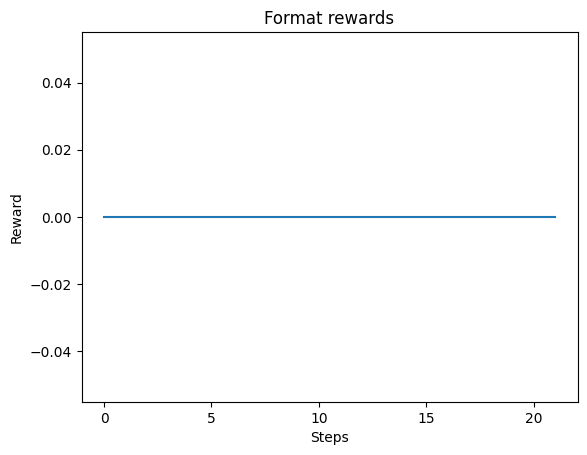

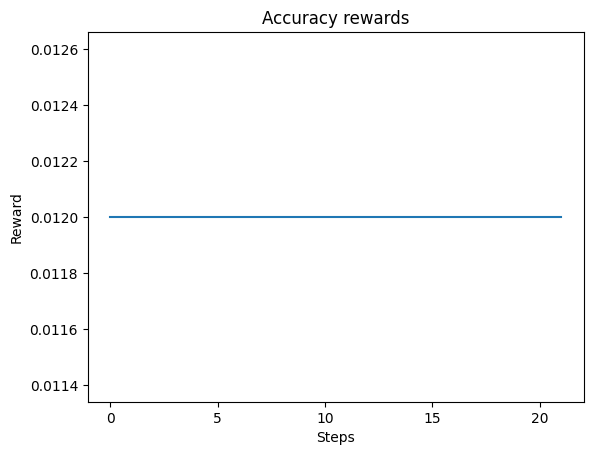

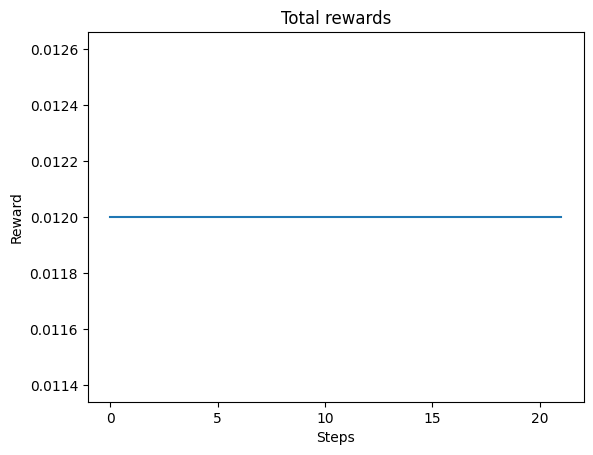

In [28]:
plt.plot(moving_average(track_format_rewards, window_size=100))
plt.title("Format rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(track_accuracy_rewards, window_size=100))
plt.title("Accuracy rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(total_rewards, window_size=100))
plt.title("Total rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()